In [79]:
using Pkg; Pkg.activate(".")
using HypergraphModularity

# using Optim 
using Plots
using TimerOutputs
using StatsBase

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [88]:
kmax = 3
n = 100
Z = rand(1:5, n)
ϑ = dropdims(ones(1,n) + rand(1,n), dims = 1)

α0 = vcat([3.0, -3.0, 10.0], [0.2, 0.4, 0.4])

function ω(p, α)
    k = sum(p)
    return sum(p)/sum((p .* (1:length(p)).^α[k])) / n^(α[kmax+k]*k)
end

function ω₃(p, α)
    k = sum(p)
    return (length(p))^(-α[k])/n^(α[kmax+k]*k)
end

Ω₁ = buildΩ(ω, α0, kmax)
Ω₃ = buildΩ(ω₃, α0, kmax)

# all-or-nothing cut
function Ω₂(z; α, mode = "group")
    k = (mode == "group") ? length(z) : sum(z)
        
    if mode == "group"
        return length(unique!(z))^(-α[k]) / n^(α[kmax+k]*k)
    elseif mode == "partition"
        return length(z)^(-α[k]) / n^(α[kmax+k]*k)
    end
end

Ω = Ω₂

H = sampleSBM(Z, ϑ, Ω;α=α0, kmax=kmax, kmin = 1)

hypergraph
  N: Array{Int64}((100,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  E: Dict{Int64,Dict}
  D: Array{Int64}((100,)) [87, 55, 70, 65, 63, 86, 79, 88, 47, 35  …  84, 67, 68, 81, 74, 61, 61, 57, 80, 85]


In [89]:
for k = 1:kmax
    p = mean([length(partitionize(Z[e])) == 1 for e in keys(H.E[k])])
    println("k = $k: $(round(100*p, digits = 0)) % of $(length(keys(H.E[k]))) edges are within a single group.")
end

k = 1: 100.0 % of 51 edges are within a single group.
k = 2: 5.0 % of 2418 edges are within a single group.
k = 3: 99.0 % of 642 edges are within a single group.


# Dyadic Modularity

In [90]:
γ̂ = 10.0
α̂ = α0

timeAlg(expr)= @timed eval(expr)

println("DYADIC")

print(rpad("iteration", 12))
print(rpad("Q (dyadic)", 15))
print(rpad("L (dyadic)", 20))
print(rpad("Q (polyadic)", 15))
print(rpad("γ̂", 15))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  100, "-"))

weighted = false

Ẑ_dyadic = zero(Z)

for i = 1:10
    out = timeAlg(:(CliqueExpansionModularity(H, γ̂, weighted, true))) # second true adds random scan order
    Ẑ_dyadic = out[1]
    time = out[2]
    
    γ̂ = computeDyadicResolutionParameter(H, Ẑ_dyadic)
    α̂ = coordinateAscent(H, Ẑ_dyadic, Ω, α̂; n_iters = 10, amin = -10, amax = 10)
    
    Q_D = dyadicModularity(H, Ẑ_dyadic, γ̂;weighted=weighted)
    
    ω_in, ω_out = computeDyadicResolutionParameter(H, Ẑ_dyadic; mode="ω", weighted=weighted)
    L_D = dyadicLogLikelihood(H, Ẑ_dyadic, ω_in, ω_out, weighted=weighted)
    
    Q_H = modularity(H, Ẑ_dyadic, Ω; α = α̂)
    
    print(rpad("$i", 12))
    print(rpad("$(round(Q_D, digits = 3))", 15))
    print(rpad("$(round(L_D, digits = 3))", 20))
    print(rpad("$(round(Q_H, digits = 0))", 15))
    print(rpad("$(round(γ̂, digits = 3))", 15))
    print(rpad("$(length(unique(Ẑ_dyadic)))", 10))
    println(rpad("$(round(time; digits=3))", 10))
    
end

DYADIC
iteration   Q (dyadic)     L (dyadic)          Q (polyadic)   γ̂             groups    time (s)  
----------------------------------------------------------------------------------------------------
1           0.0            NaN                 -52867.0       0.0            100       0.007     
2           NaN            -1.238769e8         -52516.0       NaN            1         0.005     
3           0.0            NaN                 -52505.0       0.0            100       0.004     
4           NaN            -1.238769e8         -52516.0       NaN            1         0.004     
5           0.0            NaN                 -52505.0       0.0            100       0.004     
6           NaN            -1.238769e8         -52516.0       NaN            1         0.004     
7           0.0            NaN                 -52505.0       0.0            100       0.004     
8           NaN            -1.238769e8         -52516.0       NaN            1         0.004     
9         

# Polyadic Modularity

In [91]:
α̂ = α0

println("POLYADIC")

print(rpad("iteration", 20))
print(rpad("Q", 15))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  65, "-"))

Ẑ = zero(Z)

for i = 1:10
    out = timeAlg(:(SuperNodeLouvain(H,kmax,Ω;α=α̂, verbose=false, scan_order ="random")))
    Ẑ = out[1]
    time = out[2]
    
    
    α̂ = coordinateAscent(H, Ẑ, Ω, α̂; n_iters = 10, amin = -10, amax = 10)
    Q = modularity(H, Ẑ, Ω; α = α̂)
    
    print(rpad("$i", 20))
    print(rpad("$(round(Q, digits = 0))", 15))
    print(rpad("$(length(unique(Ẑ)))", 10))
    println(rpad("$(round(time; digits=3))", 10))
end

POLYADIC
iteration           Q              groups    time (s)  
-----------------------------------------------------------------
1                   -52867.0       100       0.623     
2                   -52418.0       57        3.734     
3                   -52089.0       36        2.696     
4                   -51885.0       25        1.819     
5                   -51488.0       15        1.402     
6                   -50655.0       10        1.01      
7                   -50083.0       5         0.513     
8                   -50069.0       5         0.53      
9                   -50064.0       5         0.555     
10                  -50062.0       5         0.499     


In [78]:
ω_in, ω_out = computeDyadicResolutionParameter(H, Ẑ_dyadic; mode="ω", weighted=true)
ω_in, ω_out = 0.5*10^(-4), 10^(-6)
L_D = dyadicLogLikelihood(H, repeat([1], n), ω_in, ω_out, weighted=weighted)

-119375.67132380694

# Figures (trying RCall)

In [27]:
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 600, :height => 300))
R"""
library(tidyverse)
"""

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.3     ✔ dplyr   1.0.0
│ ✔ tidyr   1.1.0     ✔ stringr 1.4.0
│ ✔ readr   1.3.1     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


In [28]:
R"""
df <- tibble(Dyadic = $Ẑ_dyadic, Polyadic = $Ẑ, labels = $Z)

labels <- read_csv("data/contact-primary-school/label-names-contact-primary-school.txt",
                    col_names = FALSE) %>% 
          mutate(num = row_number()) %>% 
          rename(class = X1)

labels
df <- df %>% 
    left_join(labels, by = c("labels" = "num"))

df <- df %>% 
    select(-labels) %>% 
    pivot_longer(-class) %>% 
    rename(method = name) %>% 
    group_by(method) %>% 
    group_by(class, method, value) %>% 
    summarise(n = n()) %>% 
    ungroup()
""";

# Getting there, need to figure out the right way to reorder the labels

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   X1 = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'class', 'method' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [29]:
R"""
reorder_df <- df %>% 
    group_by(class, method) %>% 
    summarise(main_group = max(value)) %>% 
    arrange(method, class) %>% 
    ungroup() %>%
    group_by(method) %>% 
    mutate(gr = (!duplicated(main_group)),
           new_number = cumsum(gr)) %>% 
    select(-class) %>% 
    filter(gr) %>%
    print(n = 22)
""";

# A tibble: 19 x 4
# Groups:   method [2]
   method   main_group gr    new_number
   <chr>         <int> <lgl>      <int>
 1 Dyadic            4 TRUE           1
 2 Dyadic            5 TRUE           2
 3 Dyadic            9 TRUE           3
 4 Dyadic            6 TRUE           4
 5 Dyadic            8 TRUE           5
 6 Dyadic            3 TRUE           6
 7 Dyadic            2 TRUE           7
 8 Dyadic            7 TRUE           8
 9 Dyadic            1 TRUE           9
10 Polyadic          5 TRUE           1
11 Polyadic          3 TRUE           2
12 Polyadic          8 TRUE           3
13 Polyadic         10 TRUE           4
14 Polyadic          4 TRUE           5
15 Polyadic          1 TRUE           6
16 Polyadic          6 TRUE           7
17 Polyadic          2 TRUE           8
18 Polyadic          7 TRUE           9
19 Polyadic          9 TRUE          10


┌ Warning: RCall.jl: `summarise()` regrouping output by 'class' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [30]:
R"""
df <- df %>% 
    left_join(reorder_df, by = c("method" = "method", "value" = "main_group"))
""";

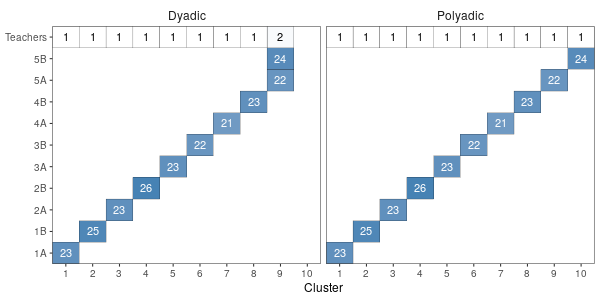

RObject{VecSxp}


In [31]:
R"""

df %>% 
    ggplot() + 
    aes(x = new_number, y = class) + 
    facet_wrap(~method) + 
    geom_tile(aes(fill = n), color = "black") + 
    theme_bw() + 
    geom_text(aes(label = n, color = n > 3)) + 
    scale_color_manual(values = c("black", "white")) + 
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(), 
          strip.background = element_blank(),
          strip.text = element_text(size = 12),
          axis.title.x = element_text(size = 12),
          axis.title.y = element_blank(),
          axis.text.x = element_text(size = 10),
          axis.text.y = element_text(size = 10)) + 
    guides(color = FALSE, fill = FALSE) + 
    scale_x_continuous(expand = c(0,0), breaks = 1:10, labels = 1:10) + 
    scale_y_discrete(expand = c(0,0)) + 
    xlab("Cluster") + 
    ylab("Class") + 
    scale_fill_gradient(low = "white", high = "steelblue")
"""

In [32]:
R"""
ggsave("fig/contact-primary-school-clustering.png", width = 6, height = 3, dpi = 200)
""";